In [33]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

%matplotlib inline

### Data preparation

#### Reading data

In [34]:
df = pd.read_csv('../data/emotions/emotions.csv')

In [35]:
df['category'] = df['category'].str.strip()

In [36]:
df.shape

(35887, 2307)

In [37]:
train = df.loc[df.category == 'Training',:]
valid = df.loc[df.category == 'PublicTest',:]
test  = df.loc[df.category == 'PrivateTest',:]

In [38]:
train.head(5)

,Unnamed: 0,y,0,1,2,3,4,5,6,7,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,category
0,0,0,70,80,82,72,58,58,60,63,...,182,183,136,106,116,95,106,109,82,Training
1,1,0,151,150,147,155,148,133,111,140,...,108,95,108,102,67,171,193,183,184,Training
2,2,2,231,212,156,164,174,138,161,173,...,138,152,122,114,101,97,88,110,152,Training
3,3,4,24,32,36,30,32,23,19,20,...,126,132,132,133,136,139,142,143,142,Training
4,4,6,4,0,0,0,0,0,0,0,...,34,31,31,31,27,31,30,29,30,Training


In [39]:
X_train = np.array(train.iloc[:, 2:2306])
y_train = np.array(train.loc[:, ['y']])

print(X_train.shape)
print(y_train.shape)

(28709, 2304)
(28709, 1)


In [40]:
X_val = np.array(valid.iloc[:, 2:2306])
y_val = np.array(valid.loc[:, ['y']])

print(X_val.shape)
print(y_val.shape)

(3589, 2304)
(3589, 1)


In [41]:
X_test = np.array(test.iloc[:, 2:2306])
y_test = np.array(test.loc[:, ['y']])

print(X_test.shape)
print(y_test.shape)

(3589, 2304)
(3589, 1)


#### Define mapping from labels to their names

In [42]:
mapping = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'   
}

#### Display some random images

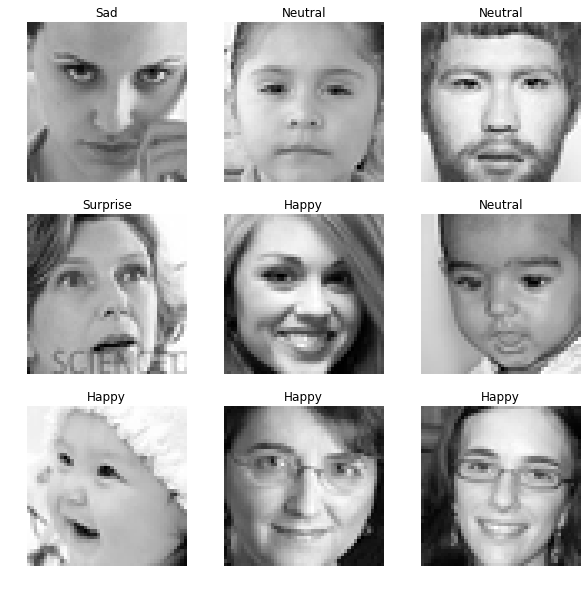

In [43]:
np.random.seed(1)

fig = plt.figure(figsize=(10, 10))

rows = 3
cols = 3

for i in range(1, rows * cols + 1):
    idx = np.random.randint(1, len(X_train))
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(X_train[idx].reshape((48,48)), cmap = 'gray')
    plt.title(mapping[y_train[idx][0]])
    plt.axis('off')
plt.show()

In [44]:
y_train = keras.utils.to_categorical(y_train, 7)
y_train.shape

(28709, 7)

In [45]:
y_val = keras.utils.to_categorical(y_val, 7)
y_val.shape

(3589, 7)

In [46]:
y_test = keras.utils.to_categorical(y_test, 7)
y_test.shape

(3589, 7)

#### Displaying total counts of different labels

In [47]:
import collections
dict(collections.Counter(np.array(train.loc[:, ['y']])[:,0]))

{0: 3995, 2: 4097, 4: 4830, 6: 4965, 3: 7215, 5: 3171, 1: 436}

### VGG Model

In [48]:
from keras.models import Sequential
from keras.optimizers import SGD,Adadelta
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D,AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import PReLU
import keras

np.random.seed(100)

#### Reshape samples

In [49]:
X_train_r = X_train.reshape((len(X_train), 48, 48, 1))
X_val_r   = X_val.reshape((len(X_val), 48, 48, 1))
X_test_r   = X_test.reshape((len(X_test), 48, 48, 1))

#### Normalize data

In [50]:
X_train_r = X_train_r / 255

In [51]:
X_val_r = X_val_r / 255

In [52]:
X_test_r = X_test_r / 255

#### Define the model

In [53]:
img_rows, img_cols = 48, 48
model = Sequential()
model.add(Conv2D(64, (5, 5), padding="valid",
                        input_shape=(img_rows, img_cols, 1)))
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(ZeroPadding2D(padding=(2, 2), data_format="channels_last"))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(Conv2D(64, (3, 3)))
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(Conv2D(64, (3, 3)))
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(Conv2D(128, (3, 3)))
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(Conv2D(128, (3, 3)))
model.add(PReLU(alpha_initializer='zero', weights=None))
 
model.add(ZeroPadding2D(padding=(1, 1), data_format="channels_last"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(PReLU(alpha_initializer='zero', weights=None))
model.add(Dropout(0.2))

model.add(Dense(7))

model.add(Activation('softmax'))

ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
model.compile(loss='categorical_crossentropy',
                  optimizer=ada,
                  metrics=['accuracy'])


In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 44, 44, 64)        123904    
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
p_re_lu_9 (PReLU)            (None, 22, 22, 64)        30976     
__________

In [55]:
batch_size = 32
epochs = 3

In [23]:
"Training with augmented data. Augmentation takes place while training"

from keras.preprocessing.image import ImageDataGenerator

#Generate augmented data
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

valgen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False) 

datagen.fit(X_train_r)
valgen.fit(X_val_r)

model.load_weights('../models/weights/vgg.h5')

model.fit(X_train_r, y_train, batch_size=32, epochs=3, validation_data=(X_val_r, y_val))

#Note: Given training is done using best checkpoint saved after 200 epochs



Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 3589 samples
Epoch 1/3
28709/28709 [==============================] - 721s 25ms/step - loss: 1.7230 - acc: 0.2995 - val_loss: 1.6615 - val_acc: 0.3488
Epoch 2/3
28709/28709 [==============================] - 528s 18ms/step - loss: 1.6450 - acc: 0.3554 - val_loss: 1.6905 - val_acc: 0.3318
Epoch 3/3
28709/28709 [==============================] - 383s 13ms/step - loss: 1.5945 - acc: 0.3813 - val_loss: 1.5738 - val_acc: 0.3957


In [57]:
model.save_weights('../models/weights/vgg.h5')

In [58]:
model_json = model.to_json()

In [59]:
with open("../models/model_deep_vgg.json", "w") as json_file:
    json_file.write(model_json)

#### Data Augmentation

In [28]:
#batch_size=32

In [32]:
#from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import array_to_img, img_to_array, load_img

#gen = ImageDataGenerator(
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True
#)

#train_generator=gen.flow(x=X_train_r, 
#                         y=y_train, 
#                         batch_size=batch_size)

In [33]:
#validation_generator=gen.flow(x=X_val_r, 
#                         y=y_val, 
#                         batch_size=batch_size)

#### Load weights of the pretrained model (since on laptop without GPU it takes nearly 8 hours to train it)

In [25]:
model.load_weights('../models/weights/vgg.h5')

#### Iteration

In [60]:
from keras.models import model_from_json

In [66]:
def read_model_from_disk(model: str, weights: str):
    
    json_file = open(model, 'r')
    
    loaded_model = json_file.read()
    
    model = model_from_json(loaded_model)
    
    model.load_weights(weights)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [67]:
model_saved = read_model_from_disk(model='../models/model_deep_vgg.json', weights='../models/weights/vgg.h5')

### Evaluations

In [68]:
model_saved.evaluate(X_test_r, y = y_test, verbose=1)

3589/3589 [==============================] - 28s 8ms/step


[1.5721516192673508, 0.39537475620365037]

Our baseline model gave `63%` accuracy on test dataset. In the original competition leaderboard, it would be in top 10 submissions. We think, that it is absolutely possible to get even higher accuracy by training the model for larger number of epochs.

### Investigation

In [69]:
from sklearn.metrics import confusion_matrix

During the data analysis stage of our project we understood that the primary weakness of this dataset is its inbalanceness. We haven't tackled this issue yet (plan to do it in the next iteration), but we understood that dealing with it is a major part of this particular problem solution.

Let's take a look on the accuracy of prediction of separate classes of emotions.

In [70]:
y = pd.DataFrame(np.argmax(y_test, axis = 1), columns=['true'])

In [71]:
y['pred'] = model_saved.predict_classes(X_test_r)

In [72]:
y['true'] = y['true'].map(mapping)

In [73]:
y['pred'] = y['pred'].map(mapping)

In [74]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict = {'fontsize': 20})
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

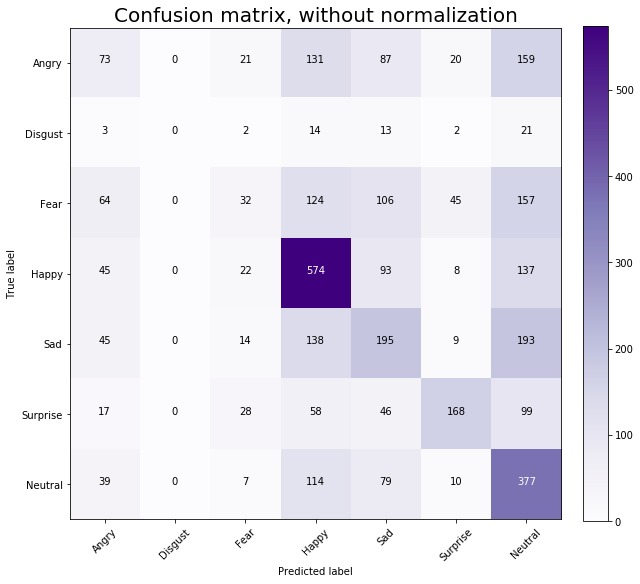

In [75]:
cnf_matrix = confusion_matrix(y['true'], y['pred'],
                              labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])

np.set_printoptions(precision=2)


plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      title='Confusion matrix, without normalization', cmap = 'Purples')

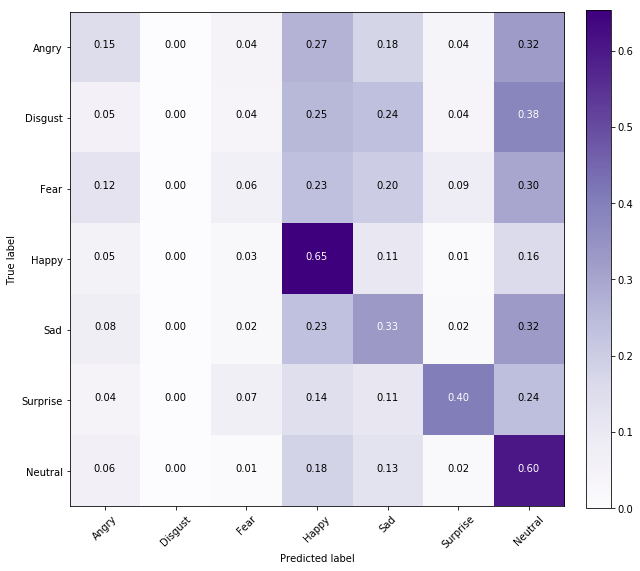

In [76]:
plt.figure(figsize=(9, 9))
plot_confusion_matrix(cnf_matrix, 
                      classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                      normalize=True,
                      title='', cmap = 'Purples')
plt.savefig('../images/confusion.png')

Looks really funny, because we've got very unexpected results. `Disgust` emotion, while being extremely underepresented is our dataset is not the one that suffers most from misclassification.

It is `Angry` and `Fear`, that model most offen treats as other facial expression.

`Fear` ia mostly confused with `Sad`. Maybe because often when a person expreriences feat, it doesn't influence her facial expression and has impact only on some inner feelings. In general, when we are afraid of something, we can have different facial expression, depending on the situation, surrounding and the cause of fear. Fear is a complex emotion there is no single facial expression that corresponds to it.

From the confusion matrix we can conclude 3 out of 6 facial expression are often confused with `Sad`. It looks like this is the most obvious way to describe the expression if we are not sure what we see. 

One important thing should be noted here: our primary assumption that accuracy of classification of images will be smaller for underrepresented classes is not confirmed by the results produced by our model.

This fact proves once again that the problem of facial expression recognition is not as simple as it seems at first sight.